# LDDMM: influence of time points

In [1]:
import shutil
from pathlib import Path

import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt

import polpo.lddmm as plddmm
from polpo.mesh.qoi import centroid2farthest_vertex, vertexwise_euclidean
from polpo.mesh.surface import PvSurface
from polpo.mesh.varifold.tuning import SigmaFromLengths
from polpo.plot.pyvista import RegisteredMeshesColoredPlotter
from polpo.preprocessing.load.pregnancy.deformetrica import get_two_random_meshes

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
RECOMPUTE = True

STATIC_VIZ = True
VIZ = 1

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
STRUCT_NAME = "L_Hipp"


OUTPUTS_DIR = Path.home() / ".polpo/results" / f"lddmm_time_points_{STRUCT_NAME}"
REGISTRATION_DIR = OUTPUTS_DIR / "registration"


if OUTPUTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(OUTPUTS_DIR)

In [4]:
meshes = get_two_random_meshes(
    OUTPUTS_DIR,
    mesh_names=("source", "target"),
    target_reduction=0,
)

In [5]:
if VIZ > 1:
    pl = pv.Plotter(border=False)

    for mesh in meshes:
        pl.add_mesh(mesh.as_pv(), show_edges=True, opacity=0.6)

    pl.show()

We select the varifold kernel [using characteristic lengths](./varifold_kernel_charlen.ipynb).

In [6]:
sigma_search = SigmaFromLengths(
    ratio_charlen_mesh=2.0,
    ratio_charlen=0.25,
)

sigma_search.fit(meshes.values())

metric = sigma_search.optimal_metric_

sigma_search.sigma_

np.float64(5.529757953771692)

Following [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb).

In [7]:
mesh_filenames = list(meshes.keys())


def _registration_dir(n_time_points):
    return REGISTRATION_DIR / f"{str(n_time_points)}"


n_time_points = [10, 20, 50]

registration_kwargs = dict(
    kernel_width=4.0,
    regularisation=1.0,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    tol=1e-16,
    attachment_kernel_width=sigma_search.sigma_,
)

for n_time_points_ in n_time_points:
    registration_dir = _registration_dir(n_time_points_)

    if not registration_dir.exists():
        plddmm.registration.estimate_registration(
            mesh_filenames[0],
            mesh_filenames[1],
            output_dir=registration_dir,
            number_of_time_steps=n_time_points_,
            **registration_kwargs,
        )

Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 4.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/luisfpereira/.polpo/results/lddmm_time_points_L_Hipp/registration/10/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 420 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -1.455E+02 	 [ attachment = -5.988E+01 ; regularity = -8.561E+01 ]

--

In [8]:
reconstructed = {}
cps = {}
for n_time_points_ in n_time_points:
    registration_dir = _registration_dir(n_time_points_)
    reconstructed[n_time_points_] = PvSurface(
        plddmm.io.load_deterministic_atlas_reconstruction(registration_dir, as_pv=True)
    )
    cps[n_time_points_] = plddmm.io.load_cp(registration_dir)


[cps_.shape[0] for cps_ in cps.values()]

[420, 420, 420]

In [9]:
_, target = meshes.values()

{
    n_time_points_: metric.dist(target, reconstructed_)
    for n_time_points_, reconstructed_ in reconstructed.items()
}

{10: np.float64(4.000095767754359),
 20: np.float64(3.997204971592177),
 50: np.float64(4.027821485068969)}

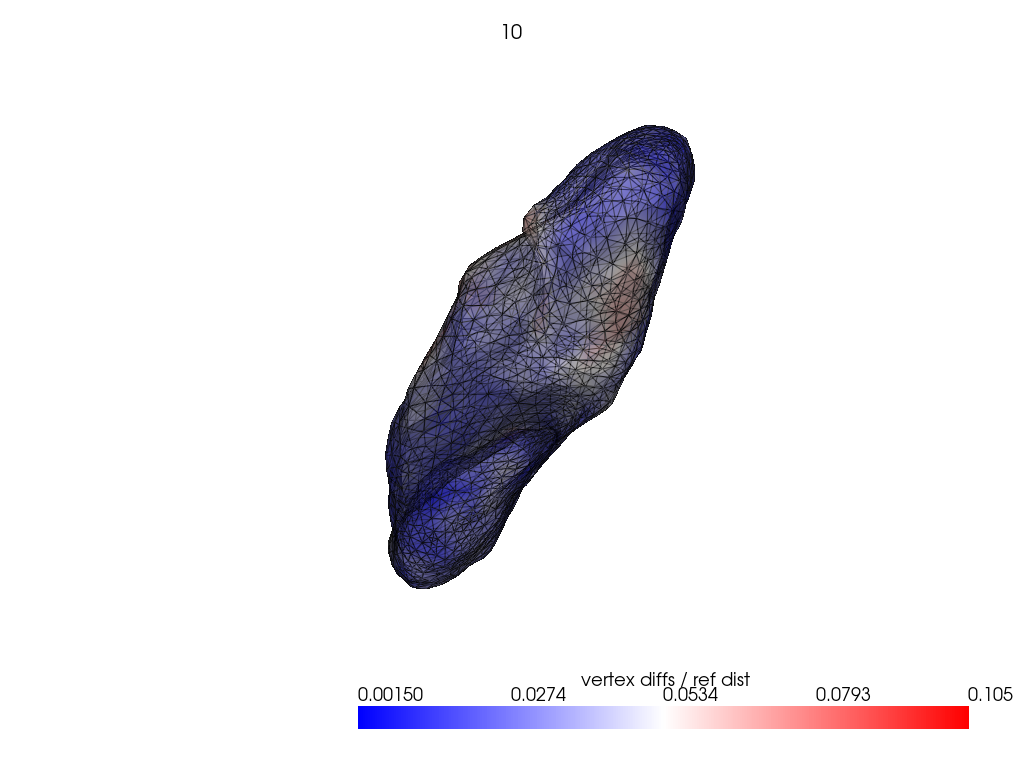

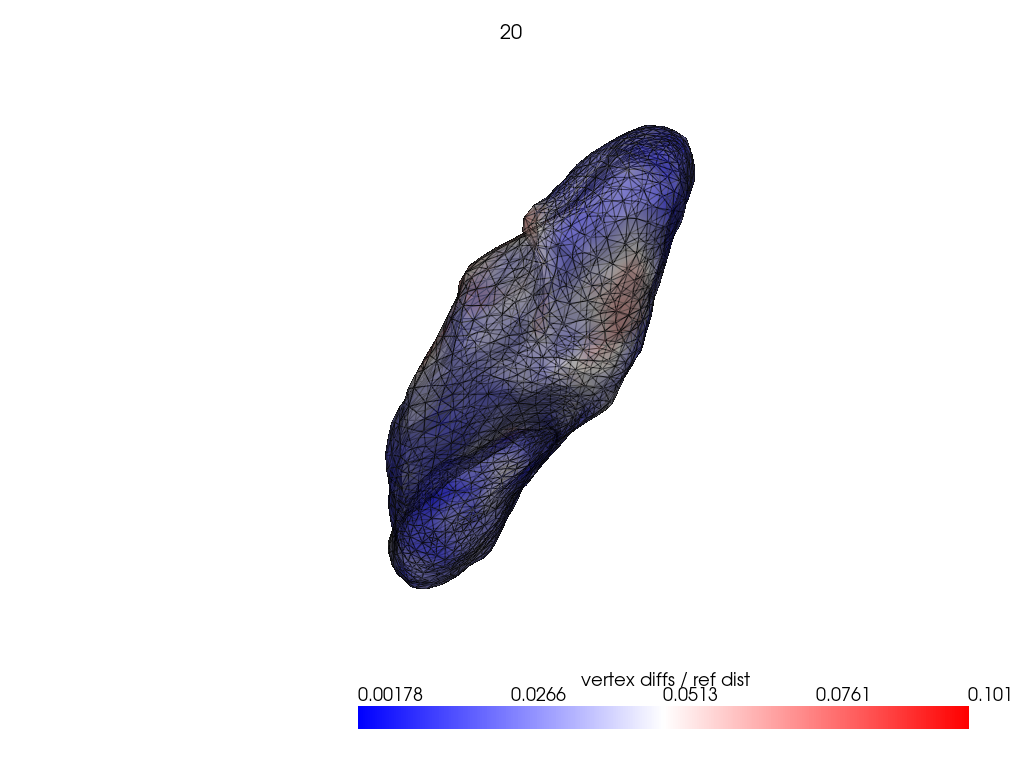

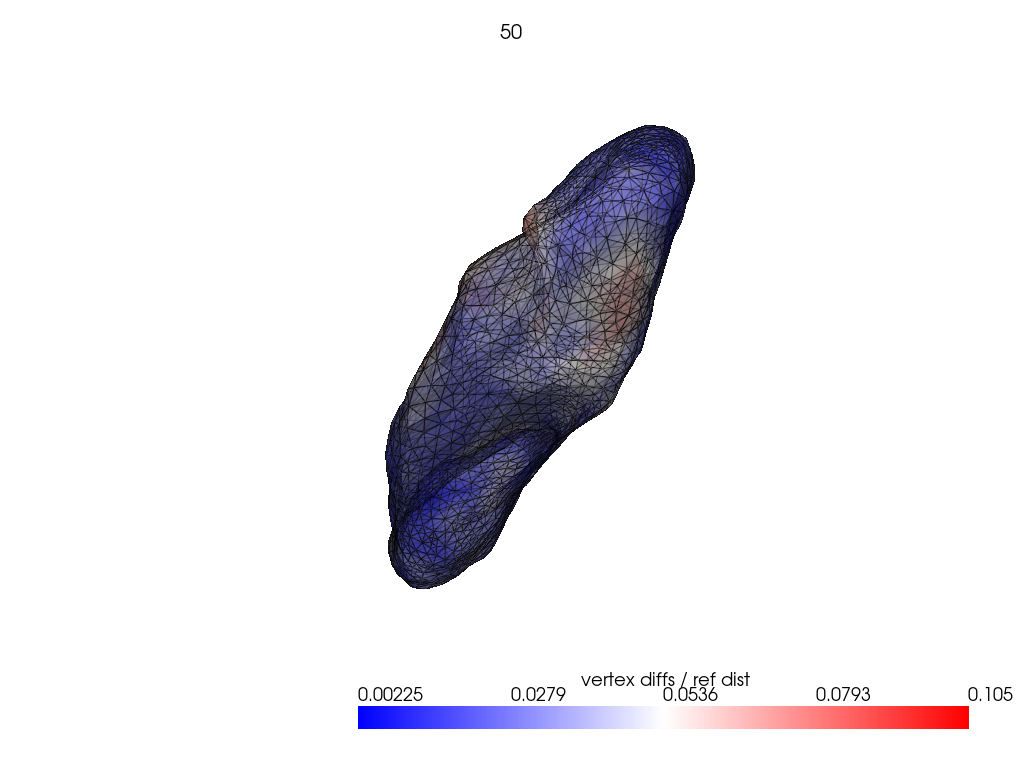

In [10]:
if VIZ > 0:
    ref_dist = centroid2farthest_vertex([target])[0]

    for name, reconstructed_ in reconstructed.items():
        pl = RegisteredMeshesColoredPlotter()

        pl.add_meshes(
            target.as_pv(),
            reconstructed_.as_pv(),
            ref_dist=ref_dist,
            show_edges=True,
            opacity=0.8,
            name="vertex diffs / ref dist",
        )

        pl.add_title(str(name), font_size=8.0)

        pl.show()

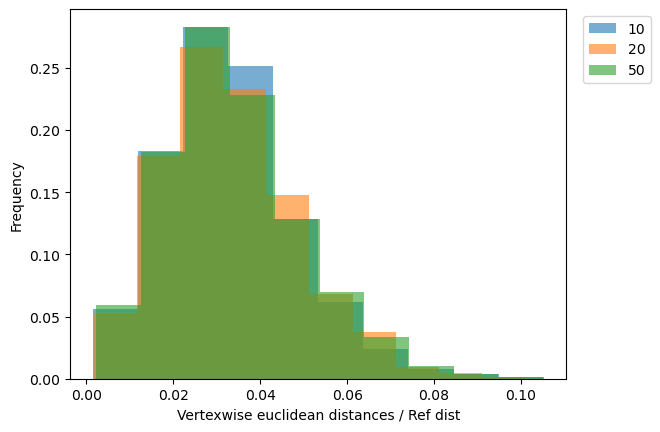

In [11]:
_, ax = plt.subplots()

for name, reconstructed_ in reconstructed.items():
    vals = vertexwise_euclidean(target, reconstructed_) / ref_dist

    ax.hist(
        vals,
        weights=1 / len(vals) * np.ones_like(vals),
        label=name,
        alpha=0.6,
    )

ax.set_xlabel("Vertexwise euclidean distances / Ref dist")
ax.set_ylabel("Frequency")

ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left");

# Further reading

* [LDDMM: influence of control points location](./lddmm_control_points.ipynb)

* [LDDMM: importance of the data attachment term](./lddmm_data_attachment.ipynb)

* [LDDMM: influence of regularisation](./lddmm_regularisation.ipynb)